In [3]:
import pickle as pkl

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.datasets import imdb
from keras.callbacks import CSVLogger

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding, GlobalMaxPooling1D
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [4]:
plt.rcParams['figure.dpi']= 150 

In [5]:
from pipe import Data

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    #ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [24]:
def trim_padding(matrices):
    ## Trim the X of -1's. Might loose actual sequences
    padding_fractions = []
    padding_fraction = 0.9

    while padding_fraction > 0.5:

        padding_fraction = len(matrices[0][np.where(matrices[0] == -1)]) / (matrices[0].shape[0] * matrices[0].shape[1])
        padding_fractions.append(padding_fraction)
        trimming_factor = 0.1
        
        for i, m in enumerate(matrices):
            matrices[i] = m[:,int(m.shape[1]*trimming_factor) : m.shape[1] - int(m.shape[1]*trimming_factor)]
            
    return matrices

def build_model():
    #embedding_dims = 16
    hidden_dims = 512
    hidden_dims_2 = 256
    hidden_dims_3 = 128
    #maxlen = 

    model = Sequential()
    #model.add(Embedding(X_0.shape[1],
    #                    embedding_dims,
    #                    input_length=maxlen))

    #model.add(Dropout(0.2))
    model.add(Conv1D(512,
                     1024,
                     activation='relu',
                     strides=2))


    model.add(GlobalMaxPooling1D())

    model.add(Dense(hidden_dims))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))

    model.add(Dense(hidden_dims_2))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))

    model.add(Dense(hidden_dims_3))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

def fit_model(X, Y, Xt, Yt, filepath):
    
    batch_size = 500
    epochs = 50

    csv_logger = CSVLogger(filepath, append=True, separator=';')

    model = build_model()

    model.fit(X[..., np.newaxis], Y,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(Xt[..., np.newaxis], Yt),
              callbacks=[csv_logger])

    return model


In [8]:
amino = Data().load_conv_train()
#gene = Data().load_conv_train(is_amino=False)

## Genes

In [7]:
targ_string = 'gene'
data = gene.copy()

In [8]:
train = data[data.set=='train'].copy()#.sample(n=500)
test  = train.sample(frac=.5, replace = True).copy()

# Remove testing indicies
train = train.loc[list(set(train.index.tolist()) - set(test.index.tolist())), :].reset_index(drop=True)
test.reset_index(drop=True, inplace=True)


In [11]:
X_0 = np.array(train['d_enc_p'].tolist())
X_1 = np.array(train['t_enc_p'].tolist())
Y = np.array(train['label'].tolist())

X_0_test = np.array(test['d_enc_p'].tolist())
X_1_test = np.array(test['t_enc_p'].tolist())
Y_test = np.array(test['label'].tolist())

trimmed = trim_padding([X_0, X_0_test])
X_0, X_0_test = trimmed[0], trimmed[1]

trimmed = trim_padding([X_1, X_1_test])
X_1, X_1_test = trimmed[0], trimmed[1]

X = np.hstack((X_0, X_1)) + 1
X_test = np.hstack((X_0_test, X_1_test)) + 1

del train, test, data, gene

In [ ]:
model=fit_model(X, Y, X_test, Y_test, 'logs/%s_log.csv'% targ_string)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 17100 samples, validate on 14074 samples
Epoch 1/25
16000/17100 [===========================>..] - ETA: 9s - loss: 1.2228 - acc: 0.5068 

In [13]:
Y_pred = model.predict(X_test[..., np.newaxis])
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

Confusion matrix, without normalization
[[3448 3547]
 [ 404 6675]]
Normalized confusion matrix
[[0.49292352 0.50707648]
 [0.05707021 0.94292979]]


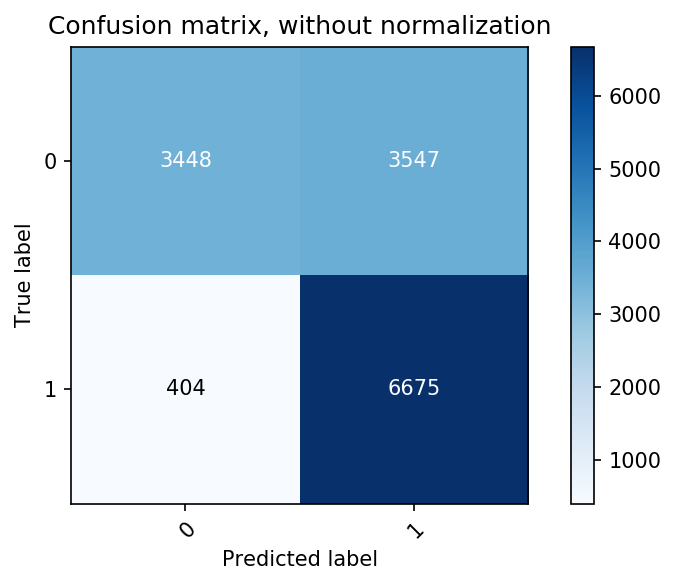

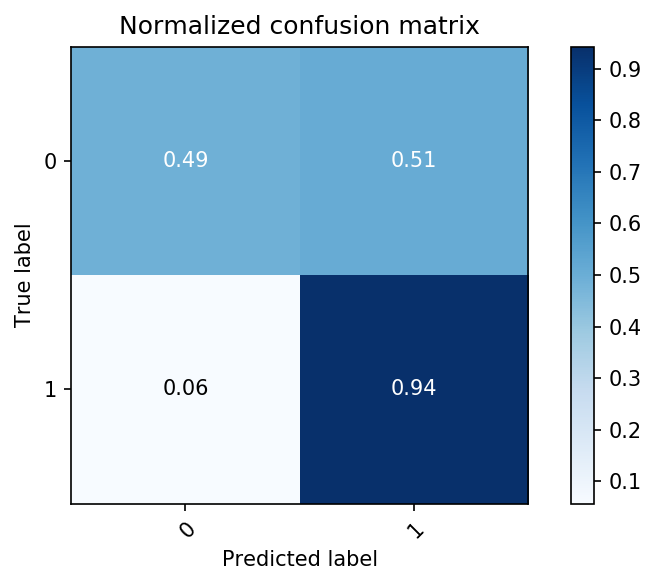

In [18]:
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

## Amino Acids

In [18]:
targ_string = 'amino'
data = amino.copy()

In [23]:
train = data[data.set=='train'].copy()#.sample(n=500)
test  = train.sample(frac=.3, replace = True).copy()

# Remove testing indicies
train = train.loc[list(set(train.index.tolist()) - set(test.index.tolist())), :].reset_index(drop=True)
test.reset_index(drop=True, inplace=True)


In [24]:
X_0 = np.array(train['d_enc_p'].tolist())
X_1 = np.array(train['t_enc_p'].tolist())
Y = np.array(train['label'].tolist())

X_0_test = np.array(test['d_enc_p'].tolist())
X_1_test = np.array(test['t_enc_p'].tolist())
Y_test = np.array(test['label'].tolist())

trimmed = trim_padding([X_0, X_0_test])
X_0, X_0_test = trimmed[0], trimmed[1]

trimmed = trim_padding([X_1, X_1_test])
X_1, X_1_test = trimmed[0], trimmed[1]

X = np.hstack((X_0, X_1)) + 1
X_test = np.hstack((X_0_test, X_1_test)) + 1

In [25]:
model=fit_model(X, Y, X_test, Y_test, 'logs/%s_log.csv'% targ_string)

Train on 20874 samples, validate on 8444 samples
Epoch 1/25
20874/20874 [==============================] - 42s 2ms/step - loss: 1.6436 - acc: 0.5049 - val_loss: 0.6918 - val_acc: 0.5019
Epoch 2/25
20874/20874 [==============================] - 40s 2ms/step - loss: 0.8034 - acc: 0.5085 - val_loss: 0.6929 - val_acc: 0.5020
Epoch 3/25
20874/20874 [==============================] - 39s 2ms/step - loss: 0.7159 - acc: 0.5045 - val_loss: 0.6898 - val_acc: 0.5239
Epoch 4/25
20874/20874 [==============================] - 40s 2ms/step - loss: 0.6970 - acc: 0.5221 - val_loss: 0.6853 - val_acc: 0.5641
Epoch 5/25
20874/20874 [==============================] - 39s 2ms/step - loss: 0.6918 - acc: 0.5323 - val_loss: 0.6815 - val_acc: 0.5743
Epoch 6/25
20874/20874 [==============================] - 41s 2ms/step - loss: 0.6855 - acc: 0.5501 - val_loss: 0.6746 - val_acc: 0.5806
Epoch 7/25
20874/20874 [==============================] - 40s 2ms/step - loss: 0.6820 - acc: 0.5594 - val_loss: 0.6714 - val_acc:

In [26]:
Y_pred = model.predict(X_test[..., np.newaxis])
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

Confusion matrix, without normalization
[[1863 2343]
 [ 155 4083]]
Normalized confusion matrix
[[0.44293866 0.55706134]
 [0.03657386 0.96342614]]


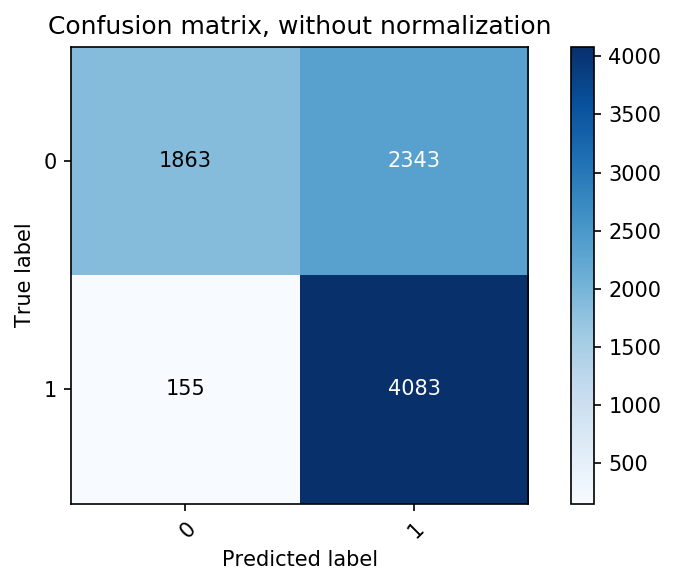

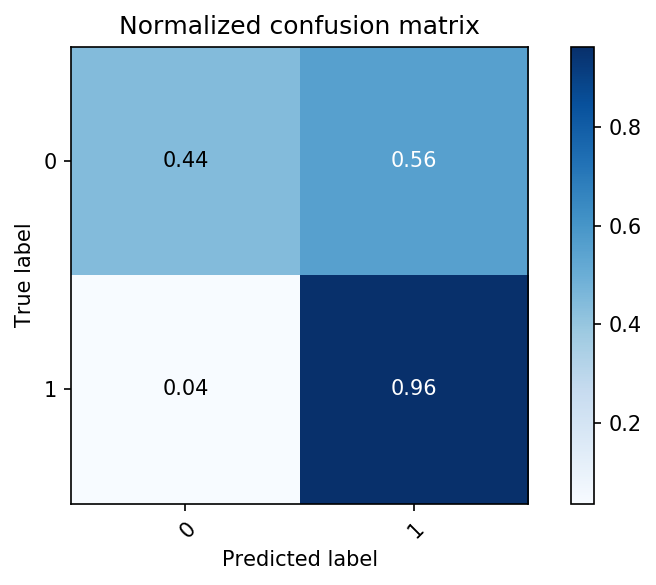

In [28]:
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

## Validation

In [10]:
data = amino.copy()

In [11]:
train = data[data.set=='train'].copy()#.sample(n=500)
test  = train.sample(frac=.3, replace = True).copy()
val   = data[data.set=='val'].copy()

# Remove testing indicies
train = train.loc[list(set(train.index.tolist()) - set(test.index.tolist())), :].reset_index(drop=True)
test.reset_index(drop=True, inplace=True)


In [12]:
X_0 = np.array(train['d_enc_p'].tolist())
X_1 = np.array(train['t_enc_p'].tolist())
Y = np.array(train['label'].tolist())

X_0_test = np.array(test['d_enc_p'].tolist())
X_1_test = np.array(test['t_enc_p'].tolist())
Y_test = np.array(test['label'].tolist())

X_0_val = np.array(val['d_enc_p'].tolist())
X_1_val = np.array(val['t_enc_p'].tolist())
Y_val = np.array(val['label'].tolist())

trimmed = trim_padding([X_0, X_0_test, X_0_val])
X_0, X_0_test, X_0_val = trimmed[0], trimmed[1], trimmed[2]

trimmed = trim_padding([X_1, X_1_test, X_1_val])
X_1, X_1_test,X_1_val  = trimmed[0], trimmed[1], trimmed[2]

# +1 to shift all values by 1 so the -1 padding becomes 0.
X = np.hstack((X_0, X_1)) + 1
X_test = np.hstack((X_0_test, X_1_test)) + 1
X_val = np.hstack((X_0_val, X_1_val)) + 1

In [28]:
X_mixed_index = np.random.randint(len(X), size=int(len(X)*.75))
X_val_mixed_index = np.random.randint(len(X_val), size=int(len(X_val)*.25))

In [29]:
Y[X_mixed_index].shape

(15635,)

In [30]:
Y_val[X_val_mixed_index].shape

(3494,)

In [31]:
X_mixed = np.vstack((X[X_mixed_index], X_val[X_val_mixed_index]))
X_mixed_val = np.vstack((X[~ X_mixed_index], X_val[ ~ X_val_mixed_index]))

#Y is shaped as a horizontal array
Y_mixed = np.hstack((Y[X_mixed_index], Y_val[X_val_mixed_index]))
Y_mixed_val = np.hstack((Y[~X_mixed_index], Y_val[~X_val_mixed_index]))

In [32]:
model=fit_model(X_mixed, Y_mixed, X_test, Y_test, 'logs/%s_log.csv'% targ_string)

Train on 19129 samples, validate on 8444 samples
Epoch 1/50
19129/19129 [==============================] - 48s 3ms/step - loss: 1.2882 - acc: 0.5069 - val_loss: 0.6844 - val_acc: 0.5731
Epoch 2/50
19129/19129 [==============================] - 47s 2ms/step - loss: 0.6977 - acc: 0.5260 - val_loss: 0.6821 - val_acc: 0.5726
Epoch 3/50
19129/19129 [==============================] - 46s 2ms/step - loss: 0.6874 - acc: 0.5518 - val_loss: 0.6712 - val_acc: 0.6090
Epoch 4/50
19129/19129 [==============================] - 47s 2ms/step - loss: 0.6807 - acc: 0.5670 - val_loss: 0.6548 - val_acc: 0.6335
Epoch 5/50
19129/19129 [==============================] - 50s 3ms/step - loss: 0.6587 - acc: 0.6056 - val_loss: 0.6560 - val_acc: 0.5931
Epoch 6/50
19129/19129 [==============================] - 46s 2ms/step - loss: 0.6351 - acc: 0.6368 - val_loss: 0.6025 - val_acc: 0.6599
Epoch 7/50
19129/19129 [==============================] - 46s 2ms/step - loss: 0.6069 - acc: 0.6566 - val_loss: 0.5910 - val_acc:

In [33]:
Y_pred = model.predict(X_mixed_val[..., np.newaxis])
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

Confusion matrix, without normalization
[[8019 1593]
 [1466 8051]]
Normalized confusion matrix
[[0.83426966 0.16573034]
 [0.15404014 0.84595986]]


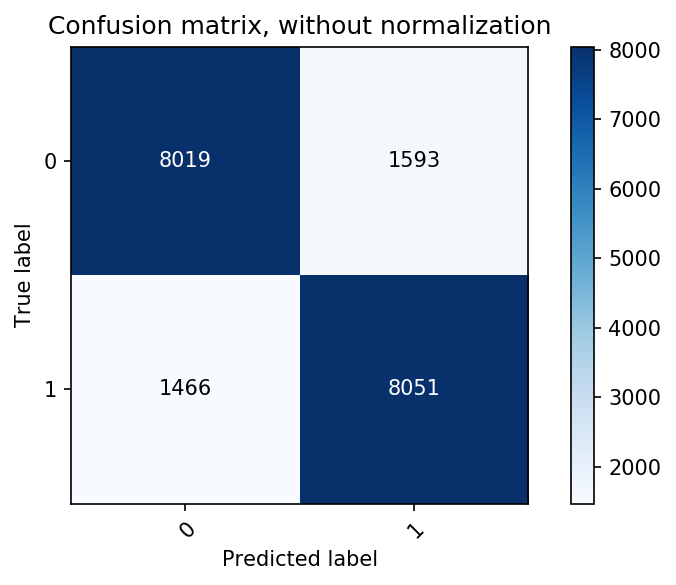

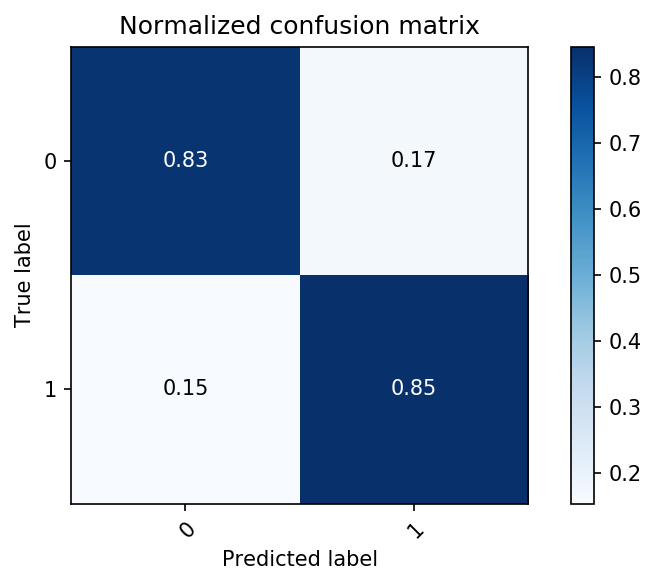

In [34]:
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_mixed_val, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
plot_model(model, show_shapes = True)

In [59]:
# model.save('data/models/pure_cnn_amino.model')